In [1]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4' 

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

E0000 00:00:1743919934.742564 1036890 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743919934.746340 1036890 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743919934.757724 1036890 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743919934.757743 1036890 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743919934.757747 1036890 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743919934.757749 1036890 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# GLOBAL VARIABLES
dataset = "wildfires"
base_dir = os.path.join("datasets", dataset)
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "valid")
augmented_dir = os.path.join(base_dir, "aug")
os.makedirs(augmented_dir, exist_ok=True)

models_dir = os.path.join("models", dataset)
os.makedirs(models_dir, exist_ok=True)

metadata_file = os.path.join(models_dir, "metadata.csv")
metrics_file = os.path.join(models_dir, "metrics.csv")

# HYPERPARAMETERS
HYPERPARAMETERS = {
    "model_version": 2,
    # Image processing
    "img_width": 128,
    "img_height": 128,
    "rescale": 1.0 / 255,
    "horizontal_flip": True,
    # Training
    "batch_size": 16,
    # Model
    "learning_rate": 0.001,
}

epochs = 100

In [4]:
import hashlib

# USING THE HYPERPARAMETERS GENERATE A KEY (HASH)
def generate_hash():
    hash_input = ""
    for key, value in HYPERPARAMETERS.items():
        if isinstance(value, list):
            value = str(value)
        hash_input += f"{key}:{value};"
    # Generate a hash
    return hashlib.md5(hash_input.encode()).hexdigest()

In [5]:
hash_key = generate_hash()

if not os.path.exists(metadata_file):
    cols = ["hash_key"]
    cols.extend(HYPERPARAMETERS.keys())
    metadata = pd.DataFrame(columns=cols)
    metadata.to_csv(metadata_file, index=False)
    
metadata = pd.read_csv(metadata_file)
if hash_key not in metadata["hash_key"].values:
    metadata = pd.read_csv(metadata_file)
    new_row = {**HYPERPARAMETERS, "hash_key": hash_key}
    metadata = pd.concat([metadata, pd.DataFrame([new_row])], ignore_index=True)
    metadata.to_csv(metadata_file, index=False)

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    horizontal_flip=HYPERPARAMETERS["horizontal_flip"],
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(HYPERPARAMETERS["img_width"], HYPERPARAMETERS["img_height"]),
    batch_size=HYPERPARAMETERS["batch_size"],
    class_mode="binary",
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    class_mode="binary",
    target_size=(HYPERPARAMETERS["img_width"], HYPERPARAMETERS["img_height"]),
    batch_size=HYPERPARAMETERS["batch_size"],
)

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


In [7]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(
    layers.Input(
        shape=(HYPERPARAMETERS["img_width"], HYPERPARAMETERS["img_height"], 3),
    )
)

model.add(
    layers.Conv2D(64, kernel_size=3, activation="relu", padding="same", strides=2)
)
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, kernel_size=3, activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))


model.add(layers.Conv2D(256, kernel_size=3, activation="relu", padding="same"))
model.add(layers.Conv2D(256, kernel_size=3, activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))


model.add(layers.Conv2D(512, kernel_size=3, activation="relu", padding="same"))
model.add(layers.Conv2D(512, kernel_size=3, activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))


model.add(layers.Conv2D(512, kernel_size=3, activation="relu", padding="same"))
model.add(layers.Conv2D(512, kernel_size=3, activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))


model.add(layers.Flatten())
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

I0000 00:00:1743919937.094776 1036890 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4084 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 18,666,625 (71.21 MB)

 Trainable params: 18,663,681 (71.20 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(models_dir, hash_key + "-{epoch:02d}-{val_loss:.2f}.keras"),
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=0.000001,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
    ),
]

In [8]:
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=HYPERPARAMETERS["learning_rate"]),
    metrics=["acc"],
)

In [9]:
histories = []

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=val_generator,
)
histories.append(history)



Epoch 1/100


/home/cajas/Archivos/tec/semestre_8/tc3002b/ml_benji/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1743919940.496705 1037021 service.cc:152] XLA service 0x7277e80093d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743919940.496724 1037021 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
I0000 00:00:1743919941.148289 1037021 cuda_dnn.cc:529] Loaded cuDNN version 90300


   4/1891 ━━━━━━━━━━━━━━━━━━━━ 1:28 47ms/step - acc: 0.4870 - loss: 1.6128

I0000 00:00:1743919949.802103 1037021 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1891/1891 ━━━━━━━━━━━━━━━━━━━━ 112s 53ms/step - acc: 0.8619 - loss: 0.5744 - val_acc: 0.8925 - val_loss: 0.3008 - learning_rate: 0.0010
Epoch 2/100
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 89s 47ms/step - acc: 0.9089 - loss: 0.2426 - val_acc: 0.7949 - val_loss: 0.4597 - learning_rate: 0.0010
Epoch 3/100
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 92s 49ms/step - acc: 0.9325 - loss: 0.1901 - val_acc: 0.9395 - val_loss: 0.2725 - learning_rate: 0.0010
Epoch 4/100
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 94s 50ms/step - acc: 0.9352 - loss: 0.1939 - val_acc: 0.9590 - val_loss: 0.1299 - learning_rate: 0.0010
Epoch 5/100
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 94s 50ms/step - acc: 0.9434 - loss: 0.1627 - val_acc: 0.9524 - val_loss: 0.1355 - learning_rate: 0.0010
Epoch 6/100
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 95s 50ms/step - acc: 0.9408 - loss: 0.1706 - val_acc: 0.9657 - val_loss: 0.1156 - learning_rate: 0.0010
Epoch 7/100
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 95s 50ms/step - acc: 0.9507 - loss: 0.1415 - val_acc: 0.8662 - val_loss: 0.3524 - lear

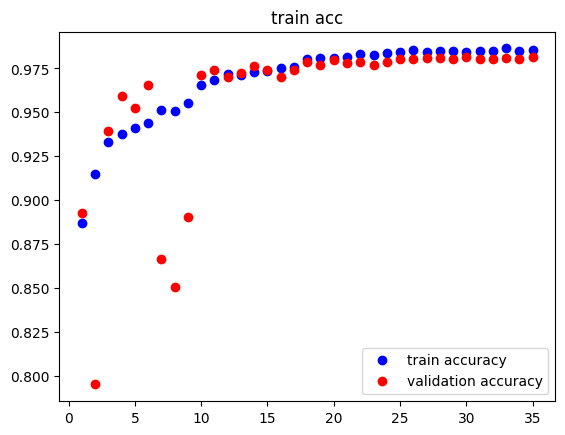

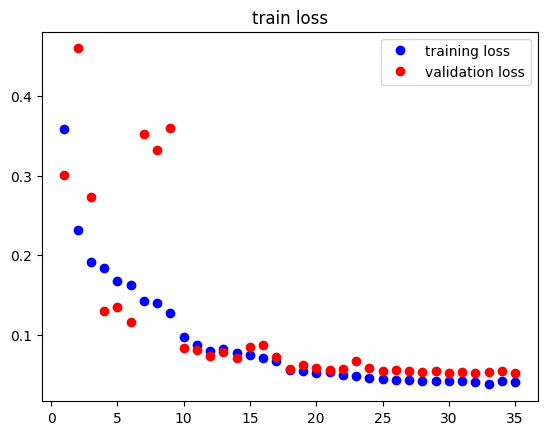

In [12]:
acc = histories[0].history['acc']
for i in range(1, len(histories)):
    acc = np.concatenate((acc, histories[i].history['acc']))

val_acc = histories[0].history['val_acc']
for i in range(1, len(histories)):
    val_acc = np.concatenate((val_acc, histories[i].history['val_acc']))

loss = histories[0].history['loss']
for i in range(1, len(histories)):
    loss = np.concatenate((loss, histories[i].history['loss']))

val_loss = histories[0].history['val_loss']
for i in range(1, len(histories)):
    val_loss = np.concatenate((val_loss, histories[i].history['val_loss']))

epochs_range = range(1, len(acc) + 1)

plt.plot(epochs_range, acc, "bo", label="train accuracy")
plt.plot(epochs_range, val_acc, "ro", label="validation accuracy")
plt.title("train acc")
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, "bo", label="training loss")
plt.plot(epochs_range, val_loss, "ro", label="validation loss")
plt.title("train loss")
plt.legend()

plt.show()

In [13]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    class_mode="binary",
    target_size=(HYPERPARAMETERS["img_width"], HYPERPARAMETERS["img_height"]),
    batch_size=20,
)

Found 6300 images belonging to 2 classes.


In [15]:
test_loss, test_acc = model.evaluate(test_generator)
print("\ntest acc :\n", test_acc)

315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - acc: 0.9864 - loss: 0.0431

test acc :
 0.9871428608894348
